In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/input/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/input/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 592 files belonging to 2 classes.
Using 474 files for training.
Found 62 files belonging to 2 classes.
Using 12 files for validation.


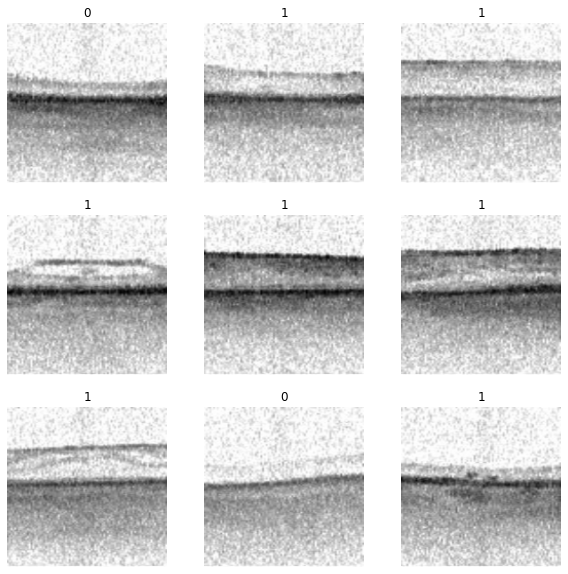

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomWidth(factor=(0.2,0.3))
    ]
)

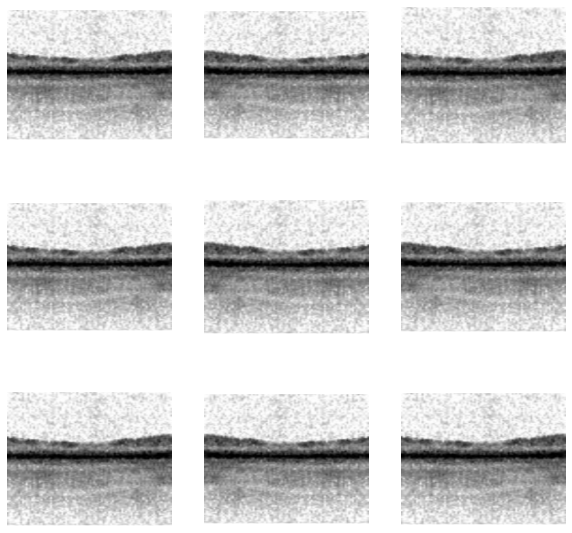

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
15/15 [==============================] - 82s 5s/step - loss: 0.4795 - accuracy: 0.7454 - val_loss: 0.7102 - val_accuracy: 0.1667
Epoch 2/50
15/15 [==============================] - 7s 473ms/step - loss: 0.2817 - accuracy: 0.8831 - val_loss: 0.7170 - val_accuracy: 0.1667
Epoch 3/50
15/15 [==============================] - 6s 395ms/step - loss: 0.2524 - accuracy: 0.8897 - val_loss: 0.7002 - val_accuracy: 0.1667
Epoch 4/50
15/15 [==============================] - 5s 336ms/step - loss: 0.1649 - accuracy: 0.9445 - val_loss: 0.7026 - val_accuracy: 0.1667
Epoch 5/50
15/15 [==============================] - 5s 306ms/step - loss: 0.1283 - accuracy: 0.9559 - val_loss: 0.6847 - val_accuracy: 0.8333
Epoch 6/50
15/15 [==============================] - 5s 306ms/step - loss: 0.1638 - accuracy: 0.9395 - val_loss: 0.6406 - val_accuracy: 0.8333
Epoch 7/50
15/15 [==============================] - 5s 308ms/step - loss: 0.1861 - accuracy: 0.9324 - val_loss: 0.6681 - val_accuracy: 0.8333
Epoch 8/

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


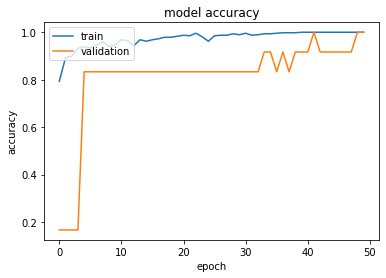

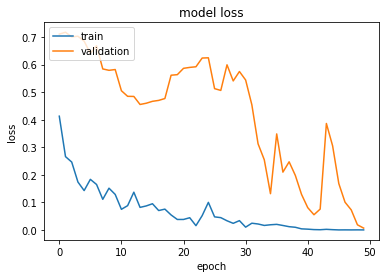

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

This image is 100.00 percent Negative and 0.00  Positive .


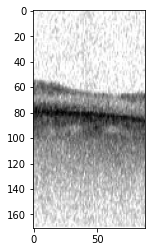

In [ ]:
import matplotlib.image as mpimg

img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/input/IOL_968_N.jpg", target_size=image_size

)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Negative and %.2f  Positive ."
    % (100 * (1 - score), 100 * score)
)

img = mpimg.imread('/content/drive/My Drive/input/IOL_968_N.jpg')
imgplot = plt.imshow(img)

This image is 0.00 percent Negative and 100.00  Positive .


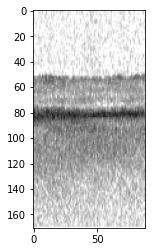

In [ ]:
import matplotlib.image as mpimg

img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/input/IOL_981_P.jpg", target_size=image_size
    
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Negative and %.2f  Positive ."
    % (100 * (1 - score), 100 * score)
)

img = mpimg.imread('/content/drive/My Drive/input/IOL_981_P.jpg')
imgplot = plt.imshow(img)